# How to `Code` a Paper

This notebook will help you regenerate some of the figures in [Churchland & Cunningham et al., 2012](https://www.nature.com/articles/nature11129), as well as understand how changing parameters in the analysis change these visualizations (and how we interpret them).

<hr>

## Setup

First, we'll clone and install a super useful **jPCA** package, written by [Benjamin Antin](https://github.com/bantin) at Columbia University. If you've already installed this package, the cell below will simply import it.

In [1]:
try:
    import jPCA
    print('jPCA imported.')
except:
    !git clone https://github.com/bantin/jPCA.git
    %cd jPCA
    !pip install .

jPCA imported.


After installing and/or importing the jPCA package, we also need to import `numpy` and `matplotlib.pyplot`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

print('Packages imported.')

Packages imported.


## Load data and inspect it

Below, we'll use the helper function `load_churchland_data` to load the Churchland & Cunningham et al. (2012) data that is hosted on the [Churchland lab website](https://churchland.zuckermaninstitute.columbia.edu/content/code). We'll also first take a look at one of the objects, `data`.

In [ ]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = '000070'  # ephys dataset from Shenoy lab
filepath = 'sub-Jenkins/sub-Jenkins_ses-20090916_behavior+ecephys.nwb'  # one file from one monkeyb

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
    
print(s3_url)

In [3]:
import urllib.request
import jPCA
from jPCA.util import load_churchland_data, plot_projections

# URL of data to download
data_url = 'https://github.com/nwb4edu/development/blob/0f181c8092d79278fcb0320d9f53bc33fbb0df85/exampleData.mat?raw=true'

# Get the data and save it locally as "sleep_data.txt"
path, headers = urllib.request.urlretrieve(data_url, './exampleData.mat')

data, times = load_churchland_data(path)

print(len(data)) # Show the length of data
data[:10]        # Look at the first 10 entries in data

108


[array([[1.60276178, 3.62279645, 1.51476444, ..., 5.60466456, 8.12611812,
         4.51181022],
        [1.55470078, 3.61949889, 1.52247338, ..., 5.8348096 , 8.39029125,
         4.49137067],
        [1.50889271, 3.6006078 , 1.51828573, ..., 6.10419168, 8.69046855,
         4.46007445],
        ...,
        [4.12529142, 0.82163592, 0.        , ..., 0.93349805, 4.08401884,
         2.88854864],
        [4.45614688, 0.75939308, 0.        , ..., 1.02900484, 3.93844586,
         2.50915528],
        [4.81611363, 0.71241948, 0.        , ..., 1.11870277, 3.78184694,
         2.23669761]]),
 array([[1.98988481e+00, 9.18115783e+00, 4.84613933e-01, ...,
         8.29134273e+00, 1.28676193e+01, 5.34669479e+00],
        [2.03938737e+00, 8.95338260e+00, 4.71113281e-01, ...,
         8.66122138e+00, 1.29588883e+01, 5.27734065e+00],
        [2.11567852e+00, 8.73625972e+00, 4.36420133e-01, ...,
         9.01331021e+00, 1.30878842e+01, 5.12815676e+00],
        ...,
        [0.00000000e+00, 8.89741886e

Hmm, why is `data` a 108-length list of arrays? If we read carefully in the paper, it says:

>"In the ‘maze task’ monkeys J and N made both straight reaches and reaches that curved around one or more intervening barriers. This task was beneficial because of the large variety of different reaches that could be evoked. Typically we used 27 conditions: each providing a particular arrangement of target and barriers. Monkey J performed the task for four different sets of 27 conditions, resulting in four datasets (J1 through J4). For the monkey J-array and N-array datasets, **108 conditions were presented in the same recording session**."

There are four different sets of 27 conditions (giving 108 total), each a different arrangement of a target and barrier. Each of the arrays within contains a time x neuron matrix for each condition (hereafter, for clarity, we'll call these **trials**. We can inspect the first array to see how many neurons there are.

In [4]:
data[0].shape

(61, 218)

In [5]:
print(len(times))  # Show the length of time
times[:10]         # Look at the first 10 entries in time

61


[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40]

The meaning of the `times` length is a bit trickier to derive from the paper, but the [documentation](https://www.dropbox.com/sh/2q3m5fqfscwf95j/AAC3WV90hHdBgz0Np4RAKJpYa?dl=0&preview=NOTES.pdf) for `exampleMat.mat` tells us that these times are in milliseconds (ms), and start 50 ms before the reach at time 0. A firing rate was sampled every 10 ms, so this is why these timestamps are 10 apart.

## Visually explore the data
Now that we understand the structure of the data, we can take a look at some of these trials. Below, we'll create a firing rate plot for one trial at a time. In this plot, each neuron will be a different color.

> **Task**: Change the value indexed in `data` below (keeping in mind how many conditions we have in total as well as 0 indexing in Python!) to look through a few different trials for patterns.

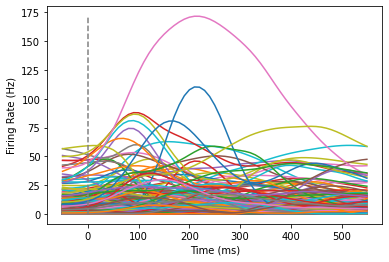

In [6]:
trial = data[10] # You can change the index here if you'd like to look through different trials.

def plotFiringRates(times,trial):    
    plt.plot(times,trial)
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (Hz)')
    plt.vlines(0,np.min(trial),np.max(trial),color='gray',linestyle='--')
    plt.show()
    
plotFiringRates(times,trial)

As you can appreciate from this plot, it is hard to make much sense of what this population of neurons are doing. Some neurons respond to the plotted condition, but not others.

We could investigate what happens if we average across all of the neurons, and then plot to compare trials against one another. In this plot, each line is a different condition.

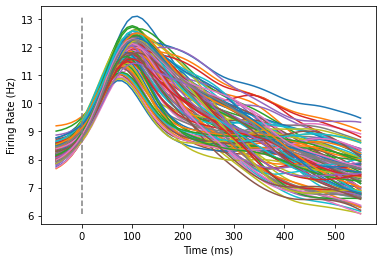

In [7]:
all_trials = np.zeros((61,108))

for idx,this_trial in enumerate(data):
    trial_average = np.mean(this_trial,axis=1)
    all_trials[:,idx] = trial_average
    
plotFiringRates(times,all_trials)

This is also not particularly informative! Clearly, neural activity increases overall when a monkey initiates a reach, but what does this tell us about neural coding?

Let's do one final check, where we look at a single cell across multiple conditions. This is similar to Figure 2 of the paper, except we won't color these by preparatory activity.

> **Task**: Change the value of `neuron` below (keeping in mind how many neurons we have in total as well as 0 indexing in Python!) to look through a few neurons for patterns.

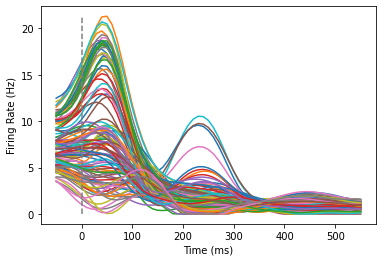

In [8]:
neuron = 200

trials_for_neuron = np.zeros((61,108))

for idx,this_trial in enumerate(data):
    trials_for_neuron[:,idx] = this_trial[:,neuron]
    
plotFiringRates(times,trials_for_neuron)

In summary, we can learn a few things away from the data exploration above:

1. Neural activity increases overall when the monkey reaches.
2. Individual neurons show different patterns of responses to reaches. Some neurons increase their firing rate to any reach, others are more selective. The timing of their firing rate variation also varies after the reach.

## jPCA 

Okay, enough of the old school, simple analyses! Below, we'll use jPCA to retain information from each individual neuron and each condition, looking at how each neuron moves through state space over time. To create our jPCA plot, we'll use the `jPCA` package.

In [ ]:
# Create a jPCA object
jpca = jPCA.JPCA(num_jpcs=6)

# Fit the jPCA object to data
projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit(data, times=times, tstart=-50, tend=150)

# Plot the projected data
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_projections(projected, axis=axes[0], x_idx=0, y_idx=1) # Plot the first jPCA plane
plot_projections(projected, axis=axes[1], x_idx=2, y_idx=3) # Plot the second jPCA plane

axes[0].set_title('jPCA Plane 1')
axes[1].set_title('jPCA Plane 2')
plt.tight_layout()
plt.show()

Above, we've generated figures really similar to Figure 3. However, the utility of working with this data live is that we can change features of the analysis and observe how this changes the plots (and our interpretation of the data).

> **Task**: Try the following with the code:
> * By default, the jPCA is fit to -50 ms to 150 ms of the data. Change `tend` to include more of the data in the analysis, and observe how this changes the PCA plots.
> * **Bonus**: What dicates the coloring of the lines here? Dig into `utils` to find out.